!pip3 install scikit-survival<br>
!pip3 install eli5

In [8]:
!pip3 install eli5

In [10]:
!pip3 install scikit-survival

  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 
# 첫 번째 줄에서 %matplotlib inline 의 역할은 notebook을 실행한 브라우저에서 바로 그림을 볼 수 있게 해주는 것

출처: https://korbillgates.tistory.com/85 [생물정보학자의 블로그]

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder

from sksurv.datasets import load_gbsg2
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest

예제데이터 불러오기

In [12]:
X, y = load_gbsg2()

In [13]:
X.head()

,age,estrec,horTh,menostat,pnodes,progrec,tgrade,tsize
0,70.0,66.0,no,Post,3.0,48.0,II,21.0
1,56.0,77.0,yes,Post,7.0,61.0,II,12.0
2,58.0,271.0,yes,Post,9.0,52.0,II,35.0
3,59.0,29.0,yes,Post,4.0,60.0,II,17.0
4,73.0,65.0,no,Post,1.0,26.0,II,35.0


In [40]:
y

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.), ( True,  577.), ( True,  184.),
       (False, 1840.), (False, 1842.), (False, 1821.), ( True, 1371.),
       ( True,  707.), (False, 1743.), (False, 1781.), ( True,  865.),
       ( True, 1684.), (False, 1701.), (False, 1701.), (False, 1693.),
       ( True,  379.), ( True, 1105.), ( True,  548.), ( True, 1296.),
       (False, 1483.), (False, 1570.), (False, 1469.), (False, 1472.),
       (False, 1342.), (False, 1349.), ( True, 1162.), (False, 1342.),
       ( True,  797.), (False, 1232.), (False, 1230.), (False, 1205.),
       (False, 1090.), (False, 1095.), ( True,  449.), (False,  972.),
       (False,  825.), (False, 2438.), (False, 2233.), ( True,  286.),
       (False, 1861.), ( True, 1080.), ( True, 1521.), (False, 1693.),
       ( True, 1528.), ( True,  169.), ( True,  272.), ( True,  731.),
      

데이터 전처리

In [18]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686 entries, 0 to 685
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       686 non-null    float64 
 1   estrec    686 non-null    float64 
 2   horTh     686 non-null    category
 3   menostat  686 non-null    category
 4   pnodes    686 non-null    float64 
 5   progrec   686 non-null    float64 
 6   tgrade    686 non-null    category
 7   tsize     686 non-null    float64 
dtypes: category(3), float64(5)
memory usage: 29.3 KB


In [14]:
# 데이터 타입을 바꿔줌
grade_str = X.loc[:, "tgrade"].astype(object).values[:, np.newaxis] # np.newaxis : 차원을 늘려줌
# 0, 1, 2 로 바꿔주는 엔코더
grade_num = OrdinalEncoder(categories=[["I", "II", "III"]]).fit_transform(grade_str)

X_no_grade = X.drop("tgrade", axis=1)
Xt = OneHotEncoder().fit_transform(X_no_grade) # 바이너리 데이터 0,1 로 변경해줌
Xt.loc[:, "tgrade"] = grade_num # tgrade에 0, 1, 2로 변경해준 값 넣어줌

In [5]:
Xt.head()

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
0,70.0,66.0,0.0,1.0,3.0,48.0,21.0,1.0
1,56.0,77.0,1.0,1.0,7.0,61.0,12.0,1.0
2,58.0,271.0,1.0,1.0,9.0,52.0,35.0,1.0
3,59.0,29.0,1.0,1.0,4.0,60.0,17.0,1.0
4,73.0,65.0,0.0,1.0,1.0,26.0,35.0,1.0


In [6]:
y

array([( True, 1814.), ( True, 2018.), ( True,  712.), ( True, 1807.),
       ( True,  772.), ( True,  448.), (False, 2172.), (False, 2161.),
       ( True,  471.), (False, 2014.), ( True,  577.), ( True,  184.),
       (False, 1840.), (False, 1842.), (False, 1821.), ( True, 1371.),
       ( True,  707.), (False, 1743.), (False, 1781.), ( True,  865.),
       ( True, 1684.), (False, 1701.), (False, 1701.), (False, 1693.),
       ( True,  379.), ( True, 1105.), ( True,  548.), ( True, 1296.),
       (False, 1483.), (False, 1570.), (False, 1469.), (False, 1472.),
       (False, 1342.), (False, 1349.), ( True, 1162.), (False, 1342.),
       ( True,  797.), (False, 1232.), (False, 1230.), (False, 1205.),
       (False, 1090.), (False, 1095.), ( True,  449.), (False,  972.),
       (False,  825.), (False, 2438.), (False, 2233.), ( True,  286.),
       (False, 1861.), ( True, 1080.), ( True, 1521.), (False, 1693.),
       ( True, 1528.), ( True,  169.), ( True,  272.), ( True,  731.),
      

<br><br><br>
Internal split validation 데이터 나누기

In [42]:
random_state = 20
X_train, X_test, y_train, y_test = train_test_split(Xt, y, test_size=0.25, random_state=random_state)

In [43]:
print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(514, 8)
(514,)
(172, 8)
(172,)


<br><br><br>
Random Forest인데, split rule이 log-rank일 뿐인 알고리즘

In [44]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           max_features="sqrt",
                           n_jobs=-1,
                           random_state=random_state)

rsf.fit(X_train, y_train)

RandomSurvivalForest(max_features='sqrt', min_samples_leaf=15,
                     min_samples_split=10, n_estimators=1000, n_jobs=-1,
                     random_state=20)

In [45]:
X_test

,age,estrec,horTh=yes,menostat=Post,pnodes,progrec,tsize,tgrade
14,70.0,139.0,1.0,1.0,3.0,113.0,22.0,1.0
270,46.0,49.0,0.0,0.0,1.0,6.0,12.0,1.0
226,72.0,1091.0,1.0,1.0,36.0,2.0,34.0,2.0
636,50.0,60.0,0.0,0.0,2.0,323.0,29.0,0.0
434,50.0,4.0,0.0,0.0,1.0,1.0,18.0,2.0
...,...,...,...,...,...,...,...,...
31,36.0,5.0,0.0,0.0,2.0,6.0,44.0,2.0
358,51.0,89.0,0.0,0.0,1.0,77.0,20.0,1.0
357,47.0,45.0,1.0,0.0,3.0,195.0,30.0,0.0
644,45.0,4.0,0.0,0.0,1.0,0.0,25.0,2.0


In [46]:
rsf.score(X_test, y_test)

0.6759696016771488

In [13]:
rsf.predict(X_test) # 리스크 수치  출력

array([ 30.48857937,  51.10857391, 148.69183517,  38.16129097,
        91.44590567,  62.10453632,  26.52193036,  97.15142192,
        95.53614184,  29.06335827,  23.48722082,  62.70842942,
        79.31593907,  41.83593395, 118.46712242,  52.00776762,
        54.54620921,  76.52632792, 169.3626459 , 180.09783904,
       152.00327962, 101.01233195,  63.31959955, 135.84213225,
        92.69888459,  94.29951525,  43.98081866,  43.3527616 ,
        61.25776562,  56.7742065 ,  43.21053694, 153.48737298,
        49.7054088 , 131.44057413,  58.28396746,  57.15191011,
       175.18013102,  73.19537819,  89.6767838 ,  41.74420722,
        45.62088346,  35.96978975, 124.8756294 , 174.16282978,
        29.16624668, 113.65324278, 120.32640045, 141.10109736,
        43.24724335,  60.46976124,  45.17618218, 162.12189729,
        45.46867297,  41.56685206,  97.26381995, 108.80511072,
        57.86610052,  32.02489704,  49.78109738,  48.69608491,
        31.97347385,  51.57422786, 159.66446656,  87.29

In [47]:
PredRes = pd.Series(rsf.predict(X_test))

In [17]:
PredRes.describe()

count    172.000000
mean      78.353405
std       41.470165
min       21.928046
25%       45.582831
50%       62.770763
75%      102.651841
max      180.097839
dtype: float64

In [18]:
y_test

array([(False, 1821.), (False, 2353.), ( True,  515.), (False, 1432.),
       (False,   17.), (False, 1868.), (False, 1781.), (False,  463.),
       (False, 1078.), ( True, 1090.), (False,  461.), ( True,  495.),
       (False,  936.), ( True,  646.), ( True,  577.), (False,  740.),
       (False, 1264.), (False, 1088.), (False, 1751.), (False,  973.),
       ( True,  420.), (False, 1720.), (False,  798.), ( True,  358.),
       ( True,  473.), (False, 2059.), (False, 1171.), (False, 1933.),
       (False, 1182.), ( True, 1253.), (False, 1632.), ( True,  859.),
       (False, 2011.), (False,  751.), (False, 1231.), (False,  148.),
       (False,  546.), ( True,  491.), ( True,  732.), (False,  892.),
       (False, 2014.), (False, 2539.), ( True,  790.), ( True,  595.),
       ( True,  876.), ( True,  981.), (False,  740.), ( True,  251.),
       (False, 1329.), (False, 1905.), (False, 1853.), (False, 1167.),
       (False, 1720.), (False, 1364.), ( True,  343.), ( True,  175.),
      

In [49]:
Event, Time = [], []
for Surv in y_test:
    Event.append(Surv[0])
    Time.append(Surv[1])    

In [50]:
FinalPred = pd.DataFrame({
    'Event':Event,
    'Time':Time,
    'Prediction':PredRes>78 # 평균 78초과로 구분
})

FinalPred

,Event,Time,Prediction
0,False,1821.0,False
1,False,2353.0,False
2,True,515.0,True
3,False,1432.0,False
4,False,17.0,True
...,...,...,...
167,False,1472.0,True
168,True,1753.0,False
169,False,2556.0,False
170,False,177.0,True


<AxesSubplot:xlabel='Time (Months)', ylabel='Survival Rate'>

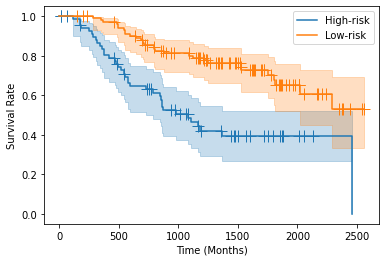

In [22]:
from lifelines import KaplanMeierFitter

treat1 = FinalPred[FinalPred['Prediction'] == True]
treat2 = FinalPred[FinalPred['Prediction'] == False]

kmf = KaplanMeierFitter()
kmf.fit(treat1['Time'], treat1['Event'], label='High-risk')
ax_kmf = kmf.plot(show_censors=True)
kmf.fit(treat2['Time'], treat2['Event'], label='Low-risk')
ax_kmf = kmf.plot(ax = ax_kmf, show_censors=True)

ax_kmf.set_xlabel('Time (Months)')
ax_kmf.set_ylabel('Survival Rate')
ax_kmf